# Graph Classification - Synthetic Data
## Experiment results

In [1]:
import comet_ml
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
from sklearn.metrics import auc
import pandas as pd

sns.set_style('white')

In [2]:
models = ['gcn', 'sage', 'gin']
types = ['base', 'transfer']

p_tags = ['p=0.1', 'p=0.5', 'p=0.9']
n_tags = ['n=10', 'n=30', 'n=50_']
std_tags = ['std=0.1', 'std=1', 'std=5.0', 'std=10.0']

default_p = 'p=0.5'
default_n = 'n=30'
default_std = 'std=1'

***
### Gathering results
Run the cell below to gather all the experiment results from  Comet.ml.

In [3]:
comet_api = comet_ml.api.API()
experiments = comet_api.get('graph-net-experiments/graph-classification-synthetic')

# gets dict with experiment_id : set of tags
experiments_with_tags = {
    exp.id: frozenset(exp.get_tags())
    for exp in experiments
}

tags = set(experiments_with_tags.values()) # gets unique tags
experiments_by_tags = { tag: [] for tag in tags } 

# experiments_by_tags: dict with all experiment ids under unique tags
for exp, exp_tags in experiments_with_tags.items():
    experiments_by_tags[exp_tags].append(exp)

In [4]:
def get_experiment_curves(exp_tag):
    losses = []
    accuracies = []

    for exp_id in experiments_by_tags[exp_tag]:
        loss = np.array([  float(step['metricValue'])
                        for step in comet_api.get_experiment_by_id(exp_id).get_metrics('train_loss')])
        acc   = np.array([  float(step['metricValue']) 
                        for step in comet_api.get_experiment_by_id(exp_id).get_metrics('accuracy')])

        losses.append(loss)
        accuracies.append(acc)
        
    losses = np.stack(losses)
    accuracies = np.stack(accuracies)

    exp_dict = {
        'losses': losses,
        'accuracies': accuracies
    }

    return exp_dict


def get_experiment_curves_by_tags(exp_tags):
    return {
        tag: get_experiment_curves(tag) for tag in exp_tags
    }

In [5]:
def check_exp_len(tag):
    for exp_id in experiments_by_tags[tag]:
        acc_len = len(comet_api.get_experiment_by_id(exp_id).get_metrics('accuracy'))
        loss_len = len(comet_api.get_experiment_by_id(exp_id).get_metrics('train_loss'))

        if acc_len < 200 or loss_len < 200:
            print(exp_id)
            print(acc_len)
            print(loss_len)
            print()


def check_exp_len_by_tags(exp_tags, label):
    print('xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx')
    print(label)

    for model in models:
        print(model)

        for tag in exp_tags[model]:
            print('-----------------------------------')
            print(tag)
            check_exp_len(tag)
            print()

In [6]:
# BASE EXPERIMENTS
base_experiment_tags = [
    frozenset({'base', model }) for model in models
]

base_experiments = get_experiment_curves_by_tags(base_experiment_tags)


# VARYING p PARAMETER
p_param_tags = {
    model:
    [
        frozenset({'N=50', 'n=30', tag, 'std=1', model, 'transfer'}) 
        for tag in p_tags
    ]

    for model in models
}

p_param_experiments = { 
    model: 
    get_experiment_curves_by_tags(p_param_tags[model]) 
    
    for model in models 
}


# VARYING n PARAMETER
n_param_tags = {
    model:
    [
        frozenset({'N=50', tag, 'p=0.5', 'std=1', model, 'transfer'}) 
        for tag in n_tags
    ]

    for model in models
}

n_param_experiments = { 
    model: 
    get_experiment_curves_by_tags(n_param_tags[model]) 
    
    for model in models
}


# VARYING std PARAMETER
std_param_tags = {
    model:
    [
        frozenset({'N=50', 'n=30', 'p=0.5', tag, model, 'transfer'}) 
        for tag in std_tags
    ]

    for model in models
}

std_param_experiments = { 
    model: 
    get_experiment_curves_by_tags(std_param_tags[model])
    
    for model in models
}

In [7]:
# check_exp_len_by_tags(base_experiment_tags, 'Base')
check_exp_len_by_tags(p_param_tags, 'p Parameter')
check_exp_len_by_tags(n_param_tags, 'n Parameter')
check_exp_len_by_tags(std_param_tags, 'std Parameter')

xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
p Parameter
gcn
-----------------------------------
frozenset({'std=1', 'gcn', 'transfer', 'N=50', 'n=30', 'p=0.1'})

-----------------------------------
frozenset({'std=1', 'gcn', 'transfer', 'N=50', 'n=30', 'p=0.5'})

-----------------------------------
frozenset({'std=1', 'gcn', 'transfer', 'N=50', 'n=30', 'p=0.9'})

sage
-----------------------------------
frozenset({'std=1', 'transfer', 'N=50', 'n=30', 'p=0.1', 'sage'})

-----------------------------------
frozenset({'std=1', 'transfer', 'N=50', 'n=30', 'p=0.5', 'sage'})

-----------------------------------
frozenset({'std=1', 'transfer', 'N=50', 'n=30', 'sage', 'p=0.9'})

gin
-----------------------------------
frozenset({'std=1', 'transfer', 'N=50', 'n=30', 'p=0.1', 'gin'})

-----------------------------------
frozenset({'std=1', 'transfer', 'N=50', 'n=30', 'p=0.5', 'gin'})

-----------------------------------
frozenset({'std=1', 'transfer', 'N=50', 'n=30', 'gin', 'p=0.9'})

xxxxxxxxxxxxxxx

In [8]:
torch.save({
    'base': base_experiments,
    'p': p_param_experiments,
    'n': n_param_experiments,
    'std': std_param_experiments
}, 
'experiment_result_dict')

### Plotting results
Alternatively, use saved results from `experiment_result_dict`.

In [9]:
experiment_results = torch.load('experiment_result_dict')

In [10]:
def get_label(tag, param='p'):
    if param == 'p':
        tag_list = p_tags
    elif param == 'n':
        tag_list = n_tags
    elif param == 'std':
        tag_list = std_tags
    
    for t in tag_list:
        if t in tag:
            return t

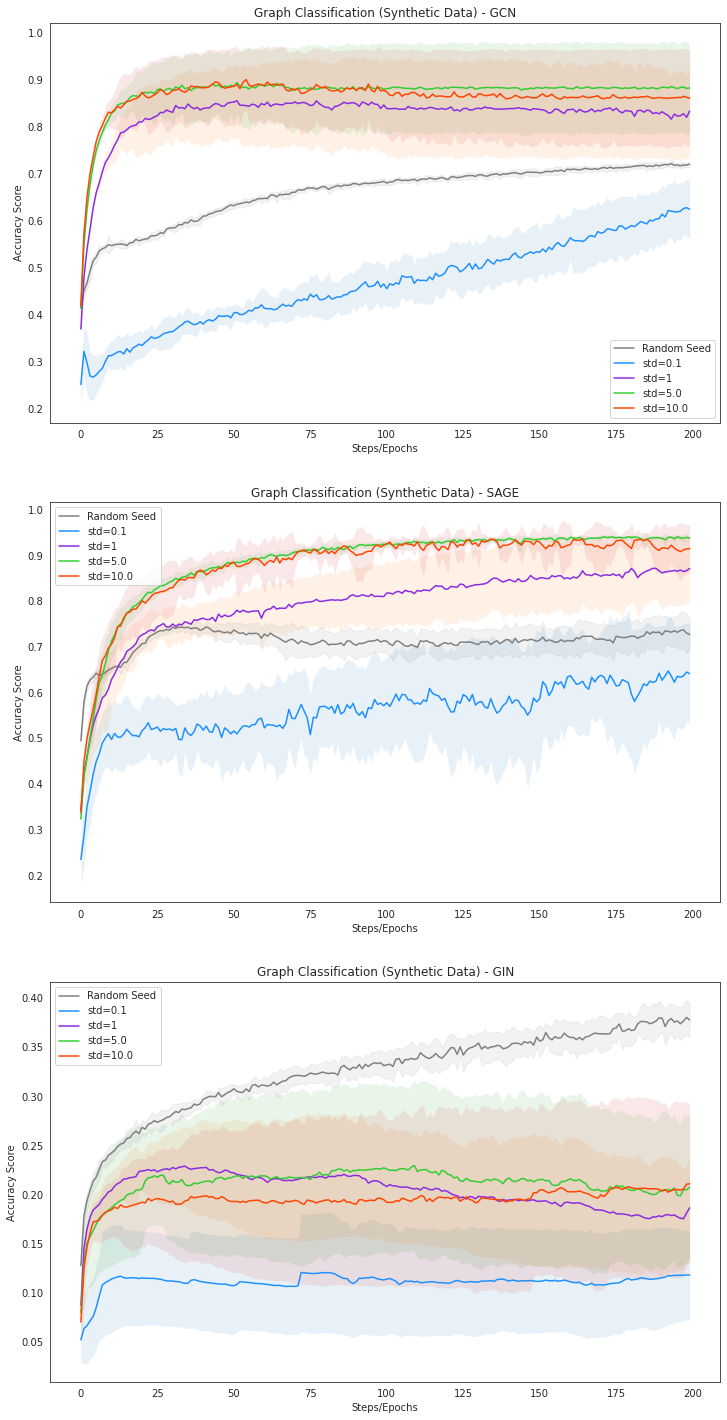

In [15]:
MODE = 'std'

colours = ['dodgerblue', 'blueviolet', 'limegreen', 'orangered']

if MODE == 'p': cols = {tag: colours[i] for i, tag in enumerate(p_tags)}
elif MODE == 'n': cols = {tag: colours[i] for i, tag in enumerate(n_tags)}
elif MODE == 'std': cols = {tag: colours[i] for i, tag in enumerate(std_tags)}

plt.figure(figsize=(12, 25))

for i, model in enumerate(models):
    plt.subplot(3,1,i+1)

    # base experiment
    base_acc = experiment_results['base'][frozenset({'base', model})]['accuracies']
    base_acc_mean = base_acc.mean(axis=0)
    base_acc_std = (base_acc_mean + base_acc.std(axis=0), base_acc_mean - base_acc.std(axis=0))

    plt.plot(base_acc.mean(axis=0), color='grey', label='Random Seed')
    plt.fill_between(np.arange(len(base_acc_mean)), base_acc_std[0], base_acc_std[1], alpha=0.1, color='grey')

    # transfer experiments
    for tag, result in experiment_results[MODE][model].items():
        label = get_label(tag, MODE)

        acc = result['accuracies']
        acc_mean = acc.mean(axis=0)
        acc_std = (acc_mean + acc.std(axis=0), acc_mean - acc.std(axis=0))

        plt.plot(acc.mean(axis=0), label=label, color=cols[label])
        plt.fill_between(np.arange(len(acc_mean)), acc_std[0], acc_std[1], alpha=0.1)
    
    plt.xlabel('Steps/Epochs')
    plt.ylabel('Accuracy Score')
    plt.title('Graph Classification (Synthetic Data) - ' + model.upper())
    plt.legend()

#### Transfer ratio

In [16]:
def transfer_ratio(base_curve, transfer_curve):
    base_auc = auc(np.arange(200), base_curve)
    transfer_auc = auc(np.arange(200), transfer_curve)

    return (transfer_auc - base_auc) / base_auc


def get_exp_transfer_ratios(base_curve, transfer_curve):
    return np.array([ transfer_ratio(b, t) for b, t in zip(base_curve, transfer_curve) ])

In [23]:
MODE='std'

transfer_ratios_list = []

for i, model in enumerate(models):
    # base experiment
    base_acc = experiment_results['base'][frozenset({'base', model})]['accuracies']

    trs = {}
    # transfer experiments
    for tag, result in experiment_results[MODE][model].items():
        transfer_acc = result['accuracies']
        transfer_ratios_ = get_exp_transfer_ratios(base_acc, transfer_acc)

        for tr in transfer_ratios_:
            tr = {'model': model, MODE: get_label(tag, MODE), 'transfer_ratio': tr}
            transfer_ratios_list.append(tr)
    
transfer_ratios_df = pd.DataFrame.from_records(transfer_ratios_list)

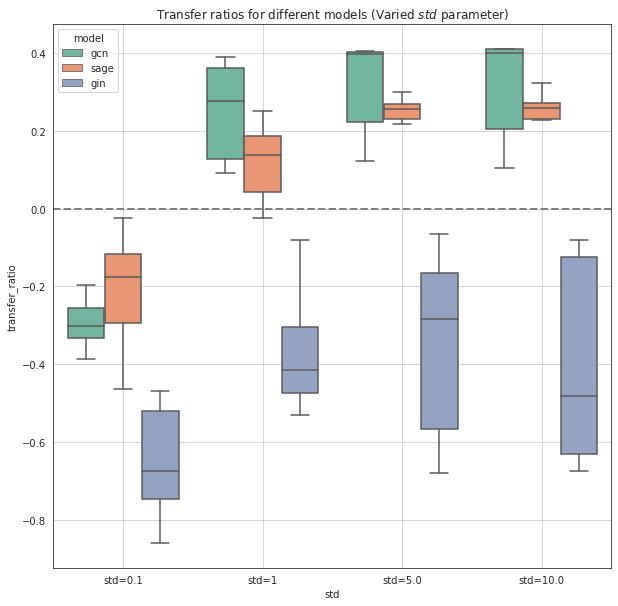

In [24]:
plt.figure(figsize=(10, 10))

ax = sns.boxplot(data=transfer_ratios_df, x=MODE, y='transfer_ratio', hue='model', palette="Set2", showfliers = False)

ax.axhline(y=0, color='grey', lw=2, linestyle='--')
# plt.fill_between([ax.get_xlim()[0], ax.get_xlim()[1]], 0, ax.get_ylim()[1], alpha=0.1, color='green')
# plt.fill_between([ax.get_xlim()[0], ax.get_xlim()[1]], ax.get_ylim()[0], 0, alpha=0.1, color='red')

ax.grid(True)
plt.title('Transfer ratios for different models (Varied ${}$ parameter)'.format(MODE));

plt.show()

#### Jumpstart

In [30]:
MODE='std'

jumpstart_list = []

for i, model in enumerate(models):
    # base experiment
    base_acc = experiment_results['base'][frozenset({'base', model})]['accuracies']

    # transfer experiments
    for tag, result in experiment_results[MODE][model].items():
        transfer_acc = result['accuracies']
        jumpstart = [t[0]-b[0] for b, t in zip(base_acc, transfer_acc)]

        for js in jumpstart:
            js = {'model': model, MODE: get_label(tag, MODE), 'jumpstart': js}
            jumpstart_list.append(js)
    
jumpstart_df = pd.DataFrame.from_records(jumpstart_list)

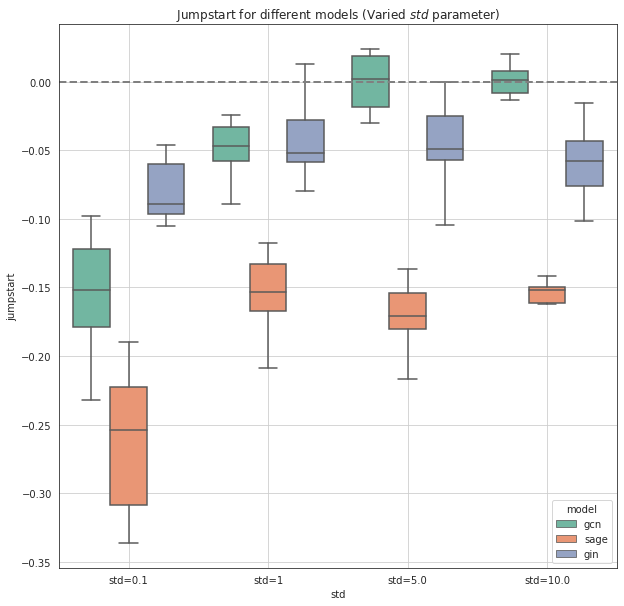

In [32]:
plt.figure(figsize=(10, 10))

ax = sns.boxplot(data=jumpstart_df, x=MODE, y='jumpstart', hue='model', palette="Set2", showfliers = False)

ax.axhline(y=0, color='grey', lw=2, linestyle='--')

ax.grid(True)
plt.title('Jumpstart for different models (Varied ${}$ parameter)'.format(MODE));

plt.show()

#### Asympototic Performance

In [37]:
MODE='std'

asympototic_perf_list = []

for i, model in enumerate(models):
    # base experiment
    base_acc = experiment_results['base'][frozenset({'base', model})]['accuracies']

    # transfer experiments
    for tag, result in experiment_results[MODE][model].items():
        transfer_acc = result['accuracies']
        asym_perf = [t[-1]-b[-1] for b, t in zip(base_acc, transfer_acc)]

        for ap in asym_perf:
            ap = {'model': model, MODE: get_label(tag, MODE), 'asymptotic_performance': ap}
            asympototic_perf_list.append(ap)
    
asymptotic_perf_df = pd.DataFrame.from_records(asympototic_perf_list)

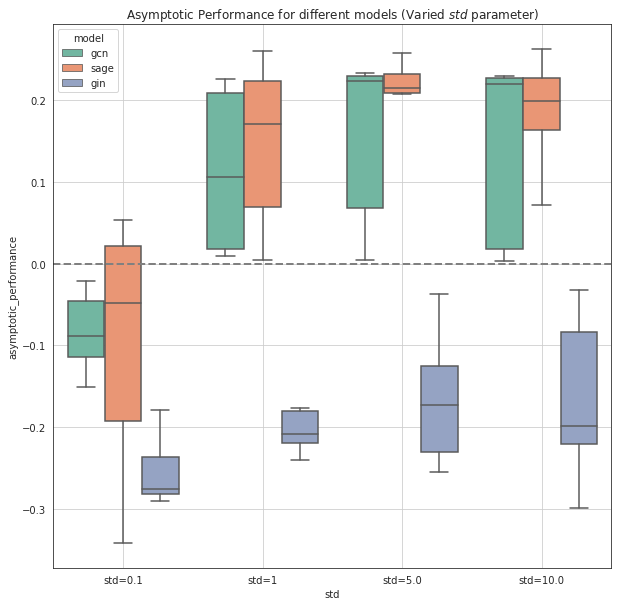

In [38]:
plt.figure(figsize=(10, 10))

ax = sns.boxplot(data=asymptotic_perf_df, x=MODE, y='asymptotic_performance', hue='model', palette="Set2", showfliers = False)

ax.axhline(y=0, color='grey', lw=2, linestyle='--')

ax.grid(True)
plt.title('Asymptotic Performance for different models (Varied ${}$ parameter)'.format(MODE));

plt.show()

#### Summary Table

In [ ]:
MODE = 'std'

summary_list = []

for model in models:
    for acc in experiment_results['base'][ frozenset({'base', model})]['accuracies']:
        record = {'model': model, 'type': 'base', 't_0_acc': acc[0], 't_n_acc': acc[-1], 'best_acc': acc.max()}
        summary_list.append(record)

    for tag, result in experiment_results[MODE][model].items():
        label = get_label(tag, MODE)
        accuracies = result['accuracies']

        for acc in accuracies:
            record = {'model': model, 'type': label, 't_0_acc': acc[0], 't_n_acc': acc[-1], 'best_acc': acc.max()}
            summary_list.append(record)

summary_df = pd.DataFrame.from_records(summary_list)

In [ ]:
mean_ = (summary_df.groupby(['model', 'type']).mean() * 100).round(2)
std_ = (summary_df.groupby(['model', 'type']).std() * 100).round(2)

mean_str = pd.DataFrame({col: mean_[col].astype(str) for col in mean_.columns})
std_str = pd.DataFrame({col: std_[col].astype(str) for col in std_.columns})

str_df = mean_str + " ± " + std_str
str_df

t_0_acc        t_n_acc      best_acc
model type                                               
gcn   base      41.41 ± 2.31    72.0 ± 0.59  72.51 ± 0.34
      std=0.1   25.23 ± 4.45    62.45 ± 6.6  64.14 ± 5.52
      std=1     37.01 ± 1.36  83.28 ± 10.23  88.74 ± 8.26
      std=10.0   41.9 ± 1.37  86.01 ± 10.69   91.7 ± 6.66
      std=5.0    41.46 ± 1.1  88.18 ± 10.14   92.13 ± 5.4
gin   base      12.15 ± 2.12   38.57 ± 2.48  39.44 ± 2.24
      std=0.1    4.31 ± 1.84    12.16 ± 6.0  15.09 ± 5.37
      std=1      8.15 ± 2.86    25.76 ± 8.8  29.55 ± 6.41
      std=10.0   6.19 ± 1.61   21.39 ± 7.51  26.76 ± 6.85
      std=5.0    10.0 ± 2.05   22.88 ± 8.64   29.32 ± 4.4
sage  base       49.41 ± 1.4   72.66 ± 3.48  76.51 ± 2.62
      std=0.1   23.41 ± 5.64  64.07 ± 11.48  70.63 ± 7.86
      std=1     34.17 ± 2.27   87.07 ± 7.39  88.37 ± 6.78
      std=10.0  33.71 ± 1.92   91.43 ± 5.39  94.46 ± 0.48
      std=5.0   32.29 ± 2.29    93.77 ± 0.6  94.75 ± 0.24